In [1]:
import glob, cv2
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from vidio.read import OpenCVReader
import multicam_calibration as mcc
from multicam_calibration.detection import _generate_chessboard_anchor_template
from pathlib import Path

## Look for the calibration files

/Users/vigji/Desktop/rig _test_videos/checkerboard0_cropped/checkerboard0_mirror_right.avi


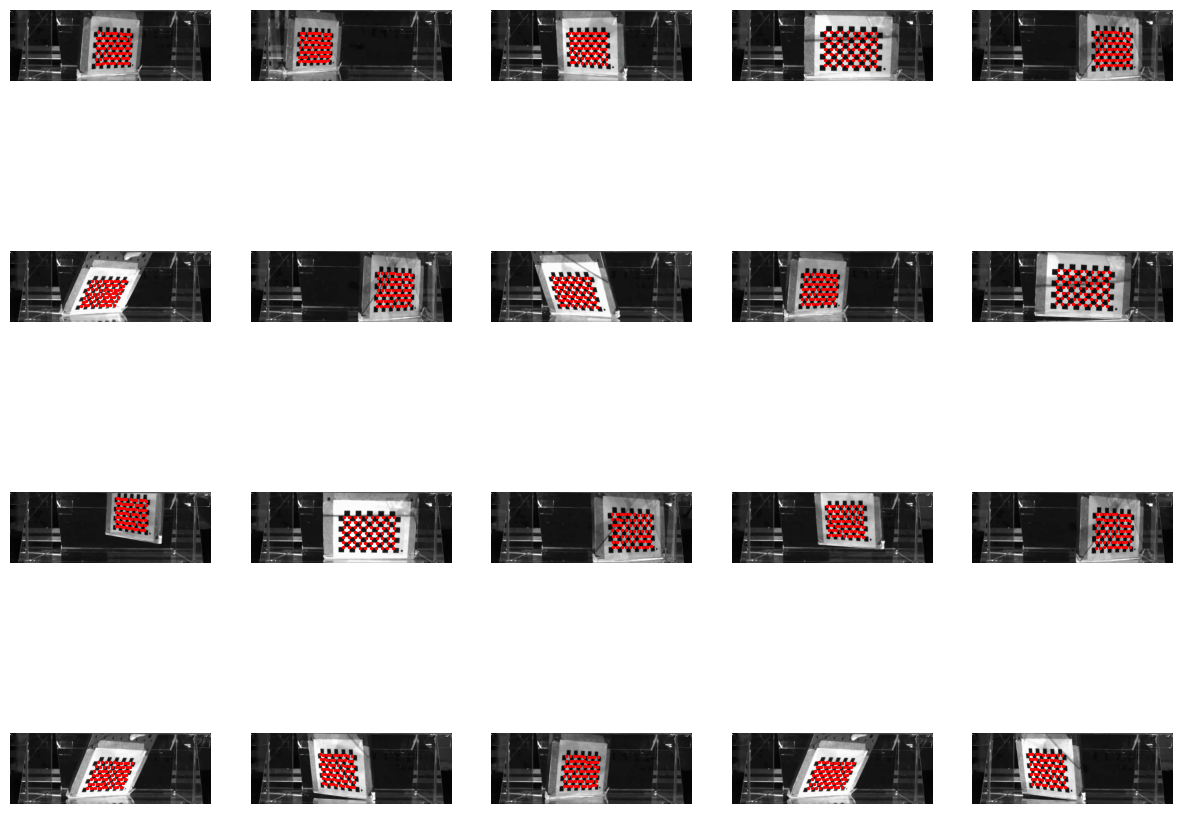

In [50]:
import h5py
from bonpy import OpenCVMovieData

video_dir = Path('/Users/vigji/Desktop/rig _test_videos/checkerboard0_cropped')
video_path = [f for f  in video_dir.glob('*.avi')][3]
print(video_path)
save_path = video_path.parent / (video_path.stem + ".detections.h5")

with h5py.File(save_path, "r") as h5:
    uvs = h5["uvs"][:]
    img_sizes = h5["img_size"][:]
    frame_ixs = h5["frame_ixs"][:]

movie_data = OpenCVMovieData(video_path)

# plot a random sample of 20 detections in a grid:

n = 20
ixs = np.random.choice(len(uvs), n, replace=False)

fig, axs = plt.subplots(4, 5, figsize=(15, 12))
axs = axs.ravel()

for i, ix in enumerate(ixs):
    img = movie_data[frame_ixs[ix]]
    ax = axs[i]
    ax.imshow(img, cmap='gray')
    ax.scatter(uvs[ix, :, 0], uvs[ix, :, 1], c='r', s=2)
    ax.axis('off')

In [62]:
def load_all_detected(video_path):
    video_path = Path(video_path)
    video_paths = video_path.glob("*.avi")
    qc_datas = []
    for video_path in video_paths:
        detections_path = video_path.parent / f"{video_path.stem}.detections.h5"
        assert video_path.exists(), (
            f"Could not find {detections_path}. "
            "Run `run_calibration_detection` first."
        )
        with h5py.File(detections_path, "r") as h5:
            qc_datas.append(h5["qc_data"][:]) 

    return qc_datas

In [64]:
data = load_all_detected("/Users/vigji/Desktop/rig _test_videos/checkerboard0_cropped")

In [69]:
data[0]

array([[-0.12980741, -0.45268831, -0.57543847, -0.60560668],
       [-0.15927057, -0.47334218, -0.50769945, -0.61987069],
       [-0.19878943, -0.43360006, -0.462539  , -0.631128  ],
       ...,
       [-0.22382838, -0.42931459, -0.58275161, -0.62045092],
       [-0.23428211, -0.44310954, -0.56395163, -0.63282281],
       [-0.09482034, -0.44055584, -0.46947097, -0.57203197]])

## Copypaste from docs

In [5]:
board_shape = (5,7)
square_size = 10

# camera_names = ['top.24562653', 'side1.24548223', 'side2.24535649', 
 #                'side4.24535665', 'side3.24562655', 'bottom.24562650']

video_dir = Path('/Users/vigji/Desktop/rig_test_videos/multicam_video_2024-04-04T16_07_59_cropped')
video_paths = [str(f) for f  in video_dir.glob('*.avi')]

# detect calibration object in each video
all_calib_uvs, all_img_sizes = mcc.run_calibration_detection(
    video_paths, mcc.detect_chessboard, n_workers=6,
    detection_options=dict(board_shape=board_shape, scale_factor=0.5))

# display a table with the detections shared between camera pairs
mcc.summarize_detections(all_calib_uvs)

# plot corner-match scores for each frame
# fig = mcc.plot_chessboard_qc_data(video_paths)

# optionally generate overlay videos
for p in video_paths:
    mcc.overlay_detections(p)


/Users/vigji/Desktop/rig_test_videos/multicam_video_2024-04-04T16_07_59_cropped/multicam_video_2024-04-04T16_07_59_mirror_bottom.overlay.mp4 already exists. Set "overwrite=True" to overwrite.
/Users/vigji/Desktop/rig_test_videos/multicam_video_2024-04-04T16_07_59_cropped/multicam_video_2024-04-04T16_07_59_mirror_top.overlay.mp4 already exists. Set "overwrite=True" to overwrite.
/Users/vigji/Desktop/rig_test_videos/multicam_video_2024-04-04T16_07_59_cropped/multicam_video_2024-04-04T16_07_59_central.overlay.mp4 already exists. Set "overwrite=True" to overwrite.
/Users/vigji/Desktop/rig_test_videos/multicam_video_2024-04-04T16_07_59_cropped/multicam_video_2024-04-04T16_07_59_mirror_right.overlay.mp4 already exists. Set "overwrite=True" to overwrite.
/Users/vigji/Desktop/rig_test_videos/multicam_video_2024-04-04T16_07_59_cropped/multicam_video_2024-04-04T16_07_59_mirror_left.overlay.mp4 already exists. Set "overwrite=True" to overwrite.


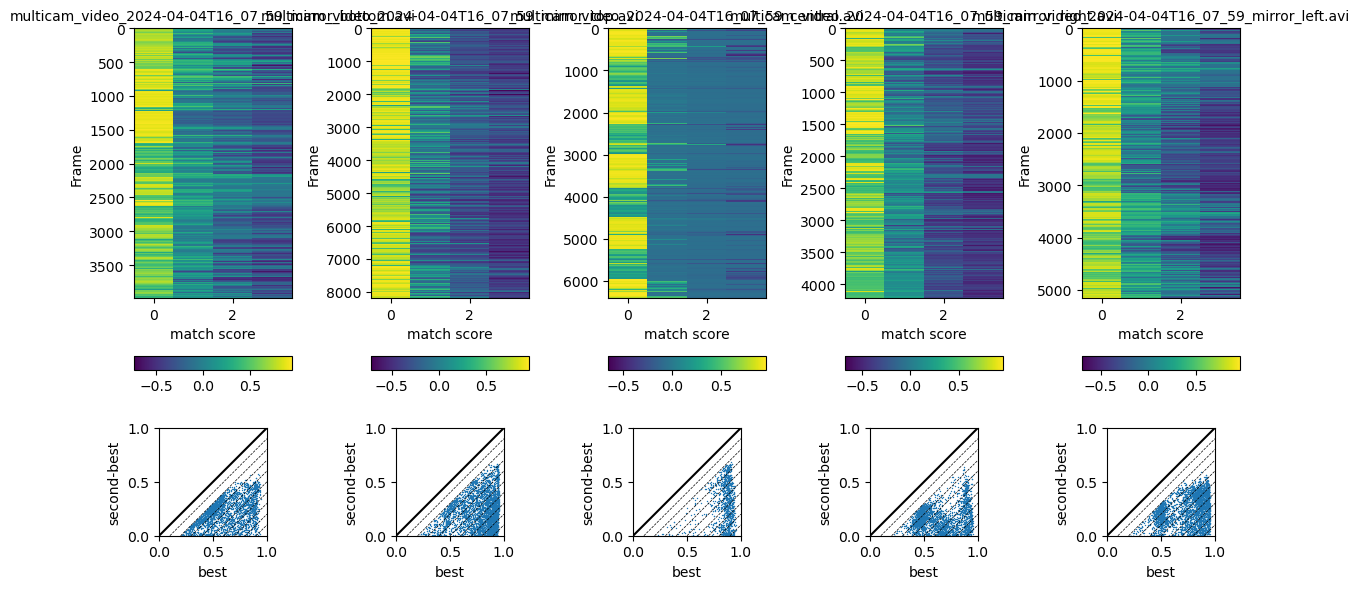

In [6]:
fig = mcc.plot_chessboard_qc_data(video_paths)

In [7]:
calib_objpoints = mcc.generate_chessboard_objpoints(board_shape, square_size)

all_extrinsics, all_intrinsics, calib_poses = mcc.calibrate(
    all_calib_uvs, all_img_sizes, calib_objpoints, root=0, n_samples_for_intrinsics=100)

Estimating camera intrinsics


100%|█████████████████████████████████████| 5/5 [00:13<00:00,  2.60s/it]


Initializing calibration object poses


100%|█████████████████████████████████████| 5/5 [00:03<00:00,  1.52it/s]


Estimating camera extrinsics
Merging calibration object poses


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


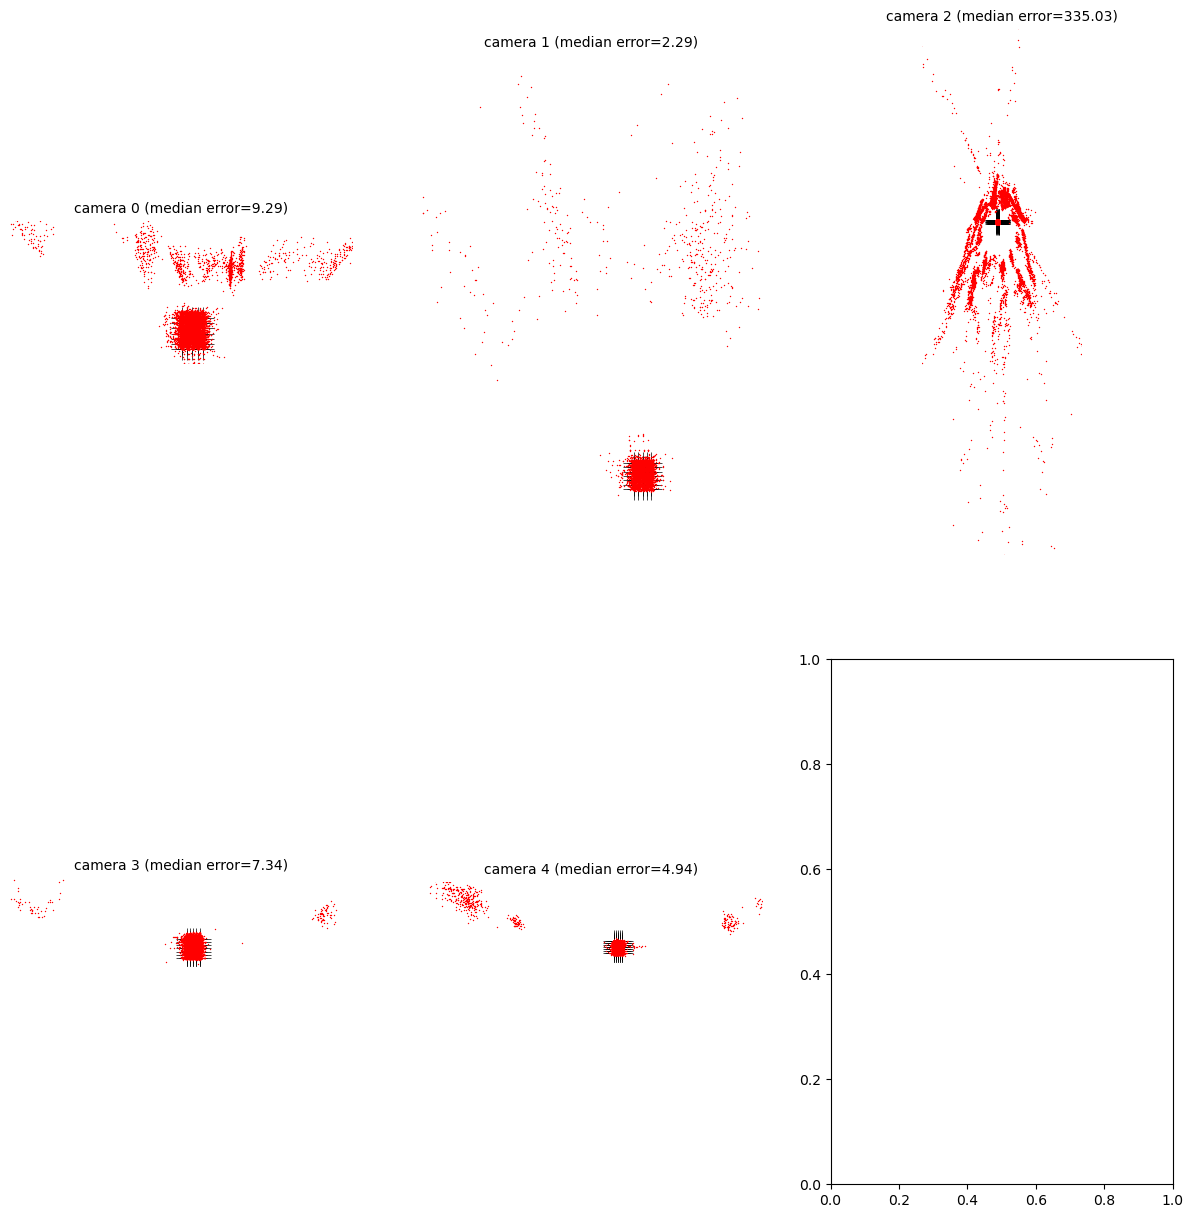

In [8]:
fig, mean_squared_error, reprojections, transformed_reprojections = mcc.plot_residuals(
    all_calib_uvs, all_extrinsics, all_intrinsics, calib_objpoints, calib_poses)

In [9]:
adj_extrinsics, adj_intrinsics, adj_calib_poses, use_frames, result = \
    mcc.bundle_adjust(all_calib_uvs, all_extrinsics, all_intrinsics, calib_objpoints, calib_poses, n_frames=5000, ftol=1e-4)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.6949e+08                                    3.60e+08    
       1              9         1.5355e+08      1.59e+07       6.39e+03       9.16e+07    
       2             10         8.3069e+07      7.05e+07       8.47e+02       9.17e+07    
       3             11         5.9863e+07      2.32e+07       2.21e+03       9.17e+07    
       4             12         5.6592e+07      3.27e+06       3.36e+03       7.70e+07    
       5             14         5.6365e+07      2.27e+05       4.13e+02       7.70e+07    
       6             15         5.6145e+07      2.20e+05       1.06e+02       7.69e+07    
       7             16         5.5732e+07      4.14e+05       8.85e+01       7.68e+07    
       8             17         5.4954e+07      7.78e+05       9.84e+01       7.66e+07    
       9             18         5.3533e+07      1.42e+06       1.14e+02       7.62e+07    

KeyboardInterrupt: 

100%|██████████| 5/5 [00:00<00:00, 26.42it/s]


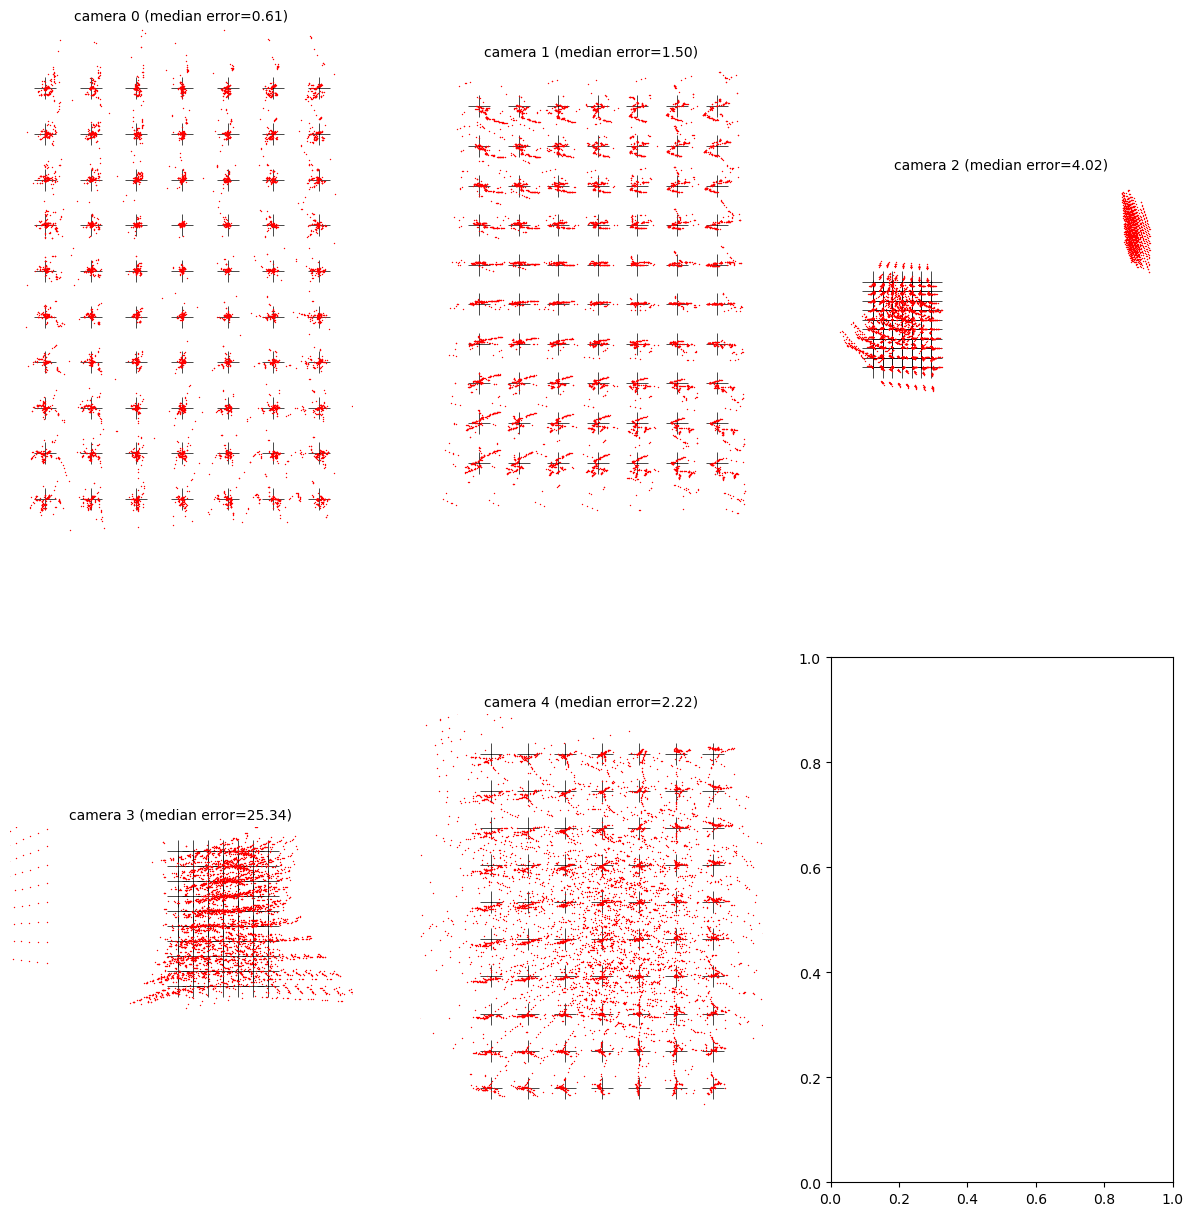

In [ ]:
fig, median_error, reprojections, transformed_reprojections = mcc.plot_residuals(
    all_calib_uvs[:,use_frames], adj_extrinsics, adj_intrinsics, calib_objpoints, adj_calib_poses)